In [1]:
import torch
from torch.autograd import Variable

## Get a state of the double integrator

<p align="center">
  <img src="double_integrator_brick.svg" width="350"/>
</p>

In [2]:
### initial state and parameters

## parameters
width  = 10.0 # width of brick in pixels
height = 5.0
t_f = 100     # number of time steps

## state
x    = 30.0 # position to right in pixels
xdot = 0.0  # 

state_initial = torch.FloatTensor([x, xdot])
state_initial = Variable(state_initial, requires_grad=False)
print state_initial

Variable containing:
 30
  0
[torch.FloatTensor of size 2]



## Just render double integrator

- Convert state of double integrator to an AABB list of corners in img
- Find all pixels inside AABB

In [3]:
import numpy as np
pi = np.pi

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50

def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]

def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()

def inside_aabb(aabb_corners, P):
    # check x conditions
    if (P[0] < aabb_corners[0][0]).all() or (P[0] > aabb_corners[3][0]).all():
        return False
    
    # check y conditions
    if (P[1] < aabb_corners[0][1]).all() or (P[1] > aabb_corners[3][1]).all():
        return False
    
    return True

def distance_to_aabb(aabb_corners, P):
    # if inside aabb, return 0
    distance_to_left   = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_top    = distance_pytorch(aabb_corners[1], aabb_corners[3], P)
    distance_to_right  = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_bottom = distance_pytorch(aabb_corners[0], aabb_corners[1], P) 

0.000490188598633  seconds for state to img


<IPython.core.display.Javascript object>


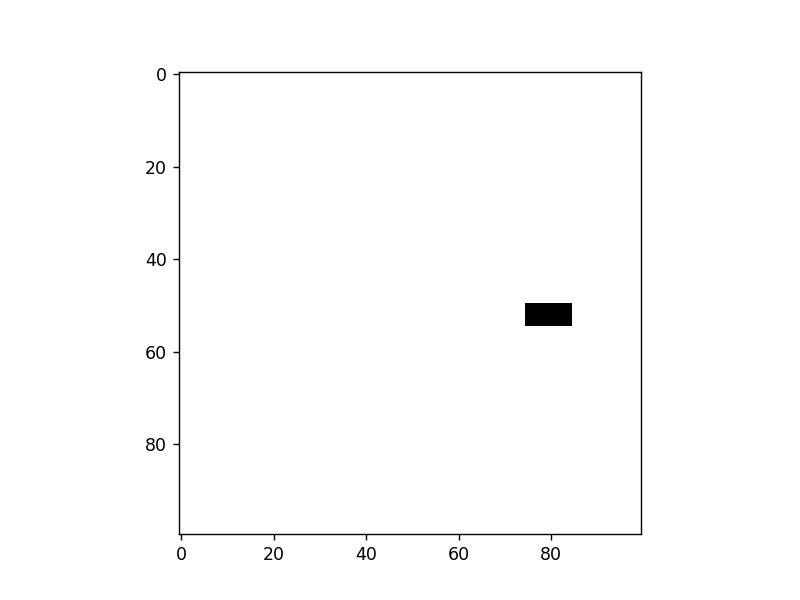

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)

def vectorized_inside_aabb(aabb_corners):
    img = Variable(torch.ones((100,100)), requires_grad=False)
    img[0:int(aabb_corners[0][0]),:] = 0.0
    img[int(aabb_corners[3][0]):,:] = 0.0
    img[:,0:int(aabb_corners[0][1])] = 0.0
    img[:,int(aabb_corners[3][1]):] = 0.0
    return img
    
def double_integrator_state_to_img(state):
    center = Variable(torch.zeros(2), requires_grad = False)
    center[1] = state[0]
    center_in_img = convert_world_to_img_coordinates(center)

    lower_left  = center + Variable(torch.FloatTensor([0,      -width/2]), requires_grad=False)
    upper_left  = center + Variable(torch.FloatTensor([height, -width/2]), requires_grad=False)
    lower_right = center + Variable(torch.FloatTensor([0,       width/2]), requires_grad=False)
    upper_right = center + Variable(torch.FloatTensor([height,  width/2]), requires_grad=False)

    corners = [lower_left, upper_left, lower_right, upper_right]
    corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]
    
    return vectorized_inside_aabb(corners_in_img)

import time; start = time.time()
img = double_integrator_state_to_img(state_initial)
print time.time() - start, " seconds for state to img"
plt.imshow(img.data, cmap=plt.get_cmap('gray_r'))
plt.show()

## State feedback: perform state feedback with just PD

In [5]:
def pd_origin_controller(state):
    x_desired = 0
    xdot_desired = 0
    diff_pos = (x_desired    - state[0])
    diff_vel = (xdot_desired - state[1])
    u = 1000*diff_pos + 100*diff_vel
    if (u > 500).all():
        u = u*0 + 500  # this trick mantains u as a Variable
    if (u < -500).all():
        u = u*0 -500
    return u

def double_integrator_next_state(state, u):
    deriv = Variable(torch.zeros(2), requires_grad = False)
    deriv[0] = state[1]
    deriv[1] = u
    dt = .01
    next_state = state + deriv*dt
    return next_state

state_tape = []
state_tape.append(state_initial)

for i in range(t_f):
    u = pd_origin_controller(state_tape[-1])
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)

101


## Convert states to imgs

In [6]:
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

101


## Visualize

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

def get_animation(img_tape):
    fig = plt.figure()
    first_img = img_tape[0].data
    im = plt.imshow(first_img, cmap='gist_gray_r')

    def init():
        im.set_data(first_img)

    def animate(i):
        im.set_data(img_tape[i].data)
        return im

    animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
    plt.close(fig)
    return animate
    
# ani = get_animation(img_tape)
# HTML(ani.to_html5_video())

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [8]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_squared = x.pow(2)
    return torch.dot(P, x_squared)

print x_i.shape
print compute_V(x_i)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]), requires_grad=True)

def compute_V_vectorized(x):
    print "compute_V_vectorized..."
    print "x.shape", x.shape
    print "P.shape", P.shape
    x_squared = x.pow(2)
    print "Punsqueezed", P.unsqueeze(1).shape
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x)

print many_x_i
print compute_V_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
Variable containing:
 2.2100
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

compute_V_vectorized...
x.shape torch.Size([2, 3])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 2.1000  3.3000  5.0000
[torch.FloatTensor of size 1x3]



In [9]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot
    
xdot = dynamics(x_i)
print xdot

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot
      
print many_x_i
print dynamics_vectorized(many_x_i)

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
-3.2000
[torch.FloatTensor of size 2]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
-3.2000 -5.5000 -8.0000
[torch.FloatTensor of size 2x3]



In [10]:
def compute_Vdot(x):
    V = compute_V(x)
    V.backward(torch.ones(1),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot
    
Vdot = compute_Vdot(x_i)
print Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_vectorized(x)
    print V
    V.backward(torch.ones(1,x.shape[1]),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    print "jacobian_x shape", jacobian_x.shape
    f = dynamics_vectorized(x)
    print "f shape", f.shape
    Vdot = (jacobian_x*f).sum(dim=0)
    print "Vdot shape", Vdot.shape
    return Vdot
    
Vdot = compute_Vdot_vectorized(many_x_i)
print Vdot
Vdot.backward(torch.ones(many_x_i.shape[1]))



Variable containing:
-4.8400
[torch.FloatTensor of size 1]

compute_V_vectorized...
x.shape torch.Size([2, 3])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 2.1000  3.3000  5.0000
[torch.FloatTensor of size 1x3]

jacobian_x shape torch.Size([2, 3])
f shape torch.Size([2, 3])
Vdot shape torch.Size([3])
Variable containing:
-2.1000
-3.3000
-5.0000
[torch.FloatTensor of size 3]



## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [11]:
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

## Now let's search for K, from an initialization not stable

In [12]:
P = Variable(torch.rand(2), requires_grad=True)
K = Variable(torch.randn(2), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.3090
 0.6096
[torch.FloatTensor of size 2]

Initial K Variable containing:
 0.1556
 1.8212
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
-0.9415
-0.1126
[torch.FloatTensor of size 2]



<IPython.core.display.Javascript object>


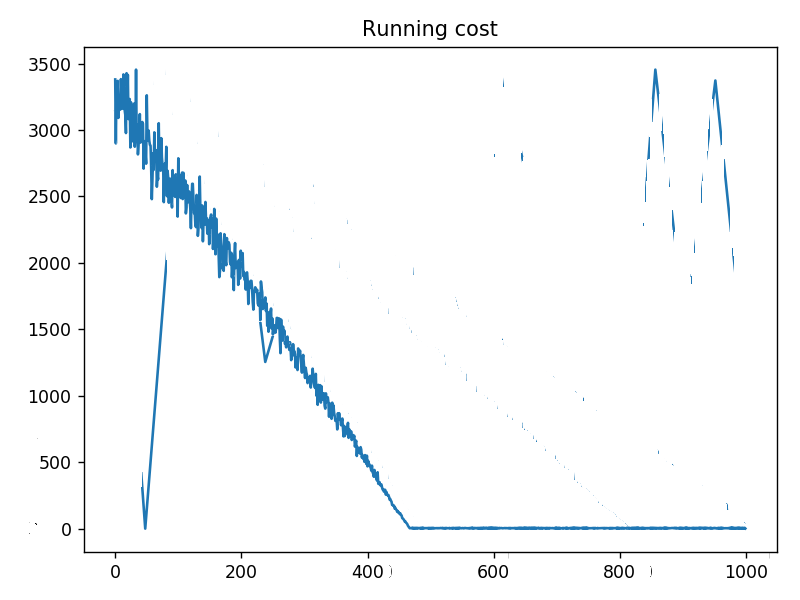

In [15]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [16]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 1000
step_rate = 1e-6

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    many_x_i = Variable(torch.randn(2,1000)*10, requires_grad=True)
    print many_x_i
    Vdot = compute_Vdot_vectorized(many_x_i)
    print "Vdot is", Vdot
    cost = Vdot.clamp(min=0).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    P.data = P.data/P.data.sum()
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 1 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K

first P is Variable containing:
 0.3361
 0.6639
[torch.FloatTensor of size 2]

first K is Variable containing:
 0.1447
 1.7288
[torch.FloatTensor of size 2]

Variable containing:
 -4.7298   6.8903  13.7786  ...   13.2902 -10.3071 -12.3403
  6.4165  10.8600 -11.2191  ...    8.2960  -1.2725   5.3055
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.6702   9.5258  -2.8174  ...    9.9745  -4.3090  -0.6252
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -4.7536
 -9.4763
  7.7824
   ⋮    
 -8.0100
  2.0229
 -3.1208
[torch.FloatTensor of size 1000]

0.0072238445282 is time for one step of grad descent

3380.73632812
P is Variable containing:
 0.3359
 0.6641
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1445
 1.7260
[torch.FloatTensor of size 2]



jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -2.5249
  7.1752
 -5.3873
   ⋮    
  4.9631
  8.2821
  0.3230
[torch.FloatTensor of size 1000]

0.00606298446655 is time for one step of grad descent

3160.11328125
P is Variable containing:
 0.3372
 0.6628
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1402
 1.6943
[torch.FloatTensor of size 2]

Variable containing:
 -8.9753  15.7206  -7.8081  ...    9.7046  17.7211   9.2155
  3.9686 -16.5392 -15.2434  ...  -10.4328  -5.1193  32.2491
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.3965  -5.6603 -12.7360  ...   -3.6419   2.5831  24.4815
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -2.2843
 11.5348
 12.7027
  

P is Variable containing:
 0.3368
 0.6632
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1353
 1.6567
[torch.FloatTensor of size 2]

Variable containing:
  4.3063 -23.5100  -5.1178  ...   12.4713   1.9688  -2.4029
  9.7093 -10.9765  -1.1053  ...   21.5134 -12.6560   0.8813
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  7.8898 -15.1973  -2.4565  ...   18.4684  -7.7309  -0.2247
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -7.7854
 10.4743
  1.3015
   ⋮    
-17.5135
  9.4679
 -0.4560
[torch.FloatTensor of size 1000]

0.00447297096252 is time for one step of grad descent

3007.30151367
P is Variable containing:
 0.3364
 0.6636
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1351
 1.6542
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3362
 0.6638
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1310
 1.6200
[torch.FloatTensor of size 2]

Variable containing:
-18.8937  -6.3382  -3.8897  ...    1.0114 -17.4561 -12.7584
 -0.6136   3.8884 -20.0327  ...   18.6337   1.2723   5.5673
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-6.7588e+00  4.5051e-01 -1.4606e+01  ...   1.2710e+01 -5.0237e+00 -5.9323e-01
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  2.0962
 -2.3234
 15.1473
   ⋮    
-13.8628
  0.5771
 -3.0064
[torch.FloatTensor of size 1000]

0.00423002243042 is time for one step of grad descent

2980.58251953
P is Variable containing:
 0.3359
 0.6641
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1309
 1.6174
[torch.FloatTensor of si

P is Variable containing:
 0.3368
 0.6632
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1279
 1.5937
[torch.FloatTensor of size 2]

Variable containing:
 10.6055  -2.1519 -17.1257  ...   -1.6868  -4.1364 -21.7879
 -0.5905  -4.2655  22.8152  ...    0.3478  -3.0308 -10.4227
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  3.1805  -3.5536   9.3623  ...   -0.3375  -3.4032 -14.2507
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -0.4740
  3.2541
-14.9775
   ⋮    
 -0.1074
  2.5333
  9.3530
[torch.FloatTensor of size 1000]

0.00399112701416 is time for one step of grad descent

2981.7824707
P is Variable containing:
 0.3363
 0.6637
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1278
 1.5910
[torch.FloatTensor of size 2]

Variable con

P is Variable containing:
 0.3365
 0.6635
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1242
 1.5679
[torch.FloatTensor of size 2]

Variable containing:
 -2.0215   1.6922  -7.2577  ...   -3.8827 -17.9939   8.0527
-10.4141   7.4236  -5.6098  ...    4.1004   3.5379  -8.9135
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -7.5901   5.4951  -6.1643  ...    1.4142  -3.7072  -3.2047
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  7.4966
 -5.3646
  4.5465
   ⋮    
 -2.5662
 -1.0075
  5.6103
[torch.FloatTensor of size 1000]

0.0040979385376 is time for one step of grad descent

2700.22729492
P is Variable containing:
 0.3364
 0.6636
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1242
 1.5654
[torch.FloatTensor of size 2]

Variable con

P is Variable containing:
 0.3361
 0.6639
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1211
 1.5392
[torch.FloatTensor of size 2]

Variable containing:
 -8.5532  -9.6262   3.8184  ...  -17.6679   5.7531   4.7163
 11.3923  11.7558  -2.5420  ...   -1.9128 -16.9817  21.8577
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  4.6886   4.5692  -0.4043  ...   -7.2081  -9.3405  16.0965
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -7.1249
 -7.2879
  1.4363
   ⋮    
  2.7317
 11.1829
-15.3680
[torch.FloatTensor of size 1000]

0.00499105453491 is time for one step of grad descent

2694.12280273
P is Variable containing:
 0.3361
 0.6639
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1208
 1.5366
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3355
 0.6645
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1180
 1.5128
[torch.FloatTensor of size 2]

Variable containing:
-16.2274  10.3260  15.0778  ...   17.8312  11.9251   3.8841
  9.1626   0.8481  13.9922  ...   -2.1270  -2.0453 -22.9518
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  0.6432   4.0283  14.3565  ...    4.5698   2.6423 -13.9473
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -4.8630
 -1.3776
-10.5519
   ⋮    
  0.0260
  0.4345
 15.0645
[torch.FloatTensor of size 1000]

0.00508499145508 is time for one step of grad descent

2502.24536133
P is Variable containing:
 0.3356
 0.6644
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1177
 1.5103
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3349
 0.6651
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1152
 1.4874
[torch.FloatTensor of size 2]

Variable containing:
 -8.0344 -15.7340   2.4039  ...  -26.7627   4.7173   7.1878
 -5.9957  -2.3906  -2.7701  ...    5.0019  -0.0486 -24.6231
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -6.6785  -6.8593  -1.0373  ...   -5.6361   1.5475 -13.9697
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  4.5391
  2.7701
  1.6284
   ⋮    
 -1.2221
 -0.3297
 15.5615
[torch.FloatTensor of size 1000]

0.00479292869568 is time for one step of grad descent

2520.61206055
P is Variable containing:
 0.3346
 0.6654
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1149
 1.4849
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3333
 0.6667
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1122
 1.4614
[torch.FloatTensor of size 2]

Variable containing:
 -1.8030  10.7466   0.8501  ...   -0.0737   5.9330  -4.9790
  6.9568  11.4115  16.0410  ...   -4.8955   0.2880  20.1343
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  4.0374  11.1899  10.9784  ...   -3.2886   2.1693  11.7648
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -4.3253
 -8.1201
-10.3479
   ⋮    
  3.1442
 -0.6284
-12.5362
[torch.FloatTensor of size 1000]

0.00498008728027 is time for one step of grad descent

2663.0168457
P is Variable containing:
 0.3331
 0.6669
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1118
 1.4587
[torch.FloatTensor of size 2]

Variable con

P is Variable containing:
 0.3335
 0.6665
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1087
 1.4348
[torch.FloatTensor of size 2]

Variable containing:
  6.8343 -12.0671   3.6746  ...   -2.6900 -27.9147  -0.9134
-16.1191  -4.1310  13.1174  ...   -3.7324   0.7784  -5.4015
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -8.4641  -6.7777   9.9682  ...   -3.3848  -8.7908  -3.9047
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  9.5439
  3.4468
 -8.4356
   ⋮    
  2.5194
  1.5371
  3.4302
[torch.FloatTensor of size 1000]

0.00462102890015 is time for one step of grad descent

2372.43383789
P is Variable containing:
 0.3338
 0.6662
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1083
 1.4323
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3318
 0.6682
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1054
 1.4002
[torch.FloatTensor of size 2]

Variable containing:
 -7.8785  16.3509  -2.8221  ...    3.0087  -8.6635   0.6902
  2.3840 -15.2098  11.8438  ...    4.1364   7.0274   2.4314
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -1.0209  -4.7387   6.9780  ...    3.7622   1.8216   1.8537
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -0.8847
  8.0330
 -6.9533
   ⋮    
 -2.7097
 -3.6334
 -1.5169
[torch.FloatTensor of size 1000]

0.00476884841919 is time for one step of grad descent

2373.61621094
P is Variable containing:
 0.3320
 0.6680
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1050
 1.3976
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3327
 0.6673
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1019
 1.3739
[torch.FloatTensor of size 2]

Variable containing:
  3.8930  18.2865   4.9276  ...  -10.9740  -2.4295   1.8920
-21.3223  -5.6214  -1.1728  ...    4.2804  -9.5658   3.5024
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-12.9337   2.3323   0.8567  ...   -0.7944  -7.1917   2.9667
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 12.1900
  2.0396
  0.3498
   ⋮    
 -1.7537
  5.7529
 -2.1745
[torch.FloatTensor of size 1000]

0.00574588775635 is time for one step of grad descent

2397.61108398
P is Variable containing:
 0.3325
 0.6675
[torch.FloatTensor of size 2]

K is Variable containing:
 0.1016
 1.3712
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3319
 0.6681
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0984
 1.3392
[torch.FloatTensor of size 2]

Variable containing:
-5.7678e+00  1.1825e+01  6.7757e+00  ...   1.1179e+01  2.8484e+00  1.1477e+01
-2.9012e-01 -4.0429e+00  1.6727e+00  ...   5.8769e+00 -1.1284e+01 -1.8090e+01
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -2.1084   1.2242   3.3666  ...    7.6369  -6.5929  -8.2753
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  0.5425
  1.4974
 -1.3868
   ⋮    
 -4.0420
  6.1622
  9.4243
[torch.FloatTensor of size 1000]

0.00411295890808 is time for one step of grad descent

2317.60375977
P is Variable containing:
 0.3318
 0.6682
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0982
 1.3364
[torch

P is Variable containing:
 0.3307
 0.6693
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0954
 1.3121
[torch.FloatTensor of size 2]

Variable containing:
 -1.0481   1.2295  20.7413  ...   -4.4035  -4.3156  -8.3231
 -5.1832 -19.8275  12.2334  ...   -6.1193   1.2514   1.7592
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -3.8159 -12.8647  15.0467  ...   -5.5520  -0.5895  -1.5747
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  2.9050
 10.7782
 -8.0234
   ⋮    
  3.6320
 -0.4095
 -0.4316
[torch.FloatTensor of size 1000]

0.00446105003357 is time for one step of grad descent

2291.14599609
P is Variable containing:
 0.3305
 0.6695
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0952
 1.3093
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3324
 0.6676
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0909
 1.2783
[torch.FloatTensor of size 2]

Variable containing:
 -7.9319  -7.7266 -14.2285  ...   -9.9223   4.8791  -2.2980
 12.4727 -11.5027   9.4201  ...    2.7490   3.3595   5.8027
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 5.6908e+00 -1.0248e+01  1.5599e+00  ...  -1.4626e+00  3.8646e+00  3.1103e+00
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -6.0170
  6.4624
 -4.0442
   ⋮    
 -0.8298
 -2.0466
 -2.8839
[torch.FloatTensor of size 1000]

0.00443196296692 is time for one step of grad descent

2066.47412109
P is Variable containing:
 0.3325
 0.6675
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0906
 1.2757
[torch.FloatTensor of si

P is Variable containing:
 0.3318
 0.6682
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0869
 1.2433
[torch.FloatTensor of size 2]

Variable containing:
  4.0502  12.4110   3.4346  ...    6.5790  12.4938   1.1535
  8.4721  -2.2262  11.3171  ...    3.7849  -7.2225  -4.5968
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  7.0048   2.6308   8.7015  ...    4.7121  -0.6801  -2.6887
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -4.4620
  0.3905
 -5.8457
   ⋮    
 -2.2702
  2.8784
  2.2265
[torch.FloatTensor of size 1000]

0.00450611114502 is time for one step of grad descent

2076.1640625
P is Variable containing:
 0.3318
 0.6682
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0866
 1.2406
[torch.FloatTensor of size 2]

Variable con

P is Variable containing:
 0.3324
 0.6676
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0833
 1.2166
[torch.FloatTensor of size 2]

Variable containing:
  8.9093   0.7062  -5.7271  ...  -11.1698  -0.3884  -0.5230
 12.2083  -6.0034   5.6800  ...   10.6556  20.4632  -6.0837
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 11.1117  -3.7732   1.8884  ...    3.4012  13.5324  -4.2354
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-6.3536e+00
 2.8413e+00
-2.4067e+00
     ⋮     
-4.4914e+00
-9.7972e+00
 2.9482e+00
[torch.FloatTensor of size 1000]

0.00417900085449 is time for one step of grad descent

1996.03308105
P is Variable containing:
 0.3321
 0.6679
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0832
 1.2138
[torch.FloatTensor of

0.00524401664734 is time for one step of grad descent

1799.52197266
P is Variable containing:
 0.3302
 0.6698
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0792
 1.1784
[torch.FloatTensor of size 2]

Variable containing:
 -5.5595  -6.7175 -25.6129  ...   22.8166   1.1319   5.0861
 -1.6348   8.7290   9.7309  ...    0.1671 -10.6878  -3.3568
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -2.9306   3.6289  -1.9388  ...    7.6454  -6.7852  -0.5692
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  1.0454
 -3.6516
 -3.1099
   ⋮    
 -1.2864
  4.8471
  1.2716
[torch.FloatTensor of size 1000]

0.00432515144348 is time for one step of grad descent

1917.76391602
P is Variable containing:
 0.3301
 0.6699
[torch.FloatTensor of size 2]

K is Variable c

P is Variable containing:
 0.3297
 0.6703
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0743
 1.1410
[torch.FloatTensor of size 2]

Variable containing:
 20.0137   0.8019  -6.0722  ...    5.0421  14.9693  -8.0109
 -3.0457  -0.6973 -10.4119  ...   -3.8032  12.8067  -9.2564
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  4.5570  -0.2030  -8.9811  ...   -0.8869  13.5197  -8.8457
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 3.2819e-01
 2.6348e-01
 4.8331e+00
     ⋮     
 1.4037e+00
-6.3184e+00
 4.4268e+00
[torch.FloatTensor of size 1000]

0.00460290908813 is time for one step of grad descent

1816.43115234
P is Variable containing:
 0.3294
 0.6706
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0741
 1.1383
[torch.FloatTensor of

P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0710
 1.1110
[torch.FloatTensor of size 2]

Variable containing:
 -7.4234  -0.1658  13.3307  ...    7.2792 -13.3182  16.2780
 13.2857 -10.0365 -25.0981  ...   -0.1519  -2.9775   7.2230
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  6.4661  -6.7860 -12.4434  ...    2.2952  -6.3827  10.2049
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -5.1713
  4.1816
  9.8022
   ⋮    
 -0.2836
  1.8726
 -3.7791
[torch.FloatTensor of size 1000]

0.00379490852356 is time for one step of grad descent

1779.1652832
P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0707
 1.1082
[torch.FloatTensor of size 2]

Variable con

P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0681
 1.0814
[torch.FloatTensor of size 2]

Variable containing:
 -2.7970   7.0518   2.7623  ...  -18.0689  -4.3762 -23.3954
 -4.6178  -1.7966   2.8116  ...    6.3114  -2.2944 -10.1512
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -4.0182   1.1172   2.7954  ...   -1.7171  -2.9799 -14.5126
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  1.9563
  0.3893
 -1.2395
   ⋮    
 -1.6737
  1.1084
  5.0882
[torch.FloatTensor of size 1000]

0.00418591499329 is time for one step of grad descent

1511.83862305
P is Variable containing:
 0.3295
 0.6705
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0676
 1.0789
[torch.FloatTensor of size 2]

Variable co

Variable containing:
  5.2197   6.1072   5.7684  ...   -7.5511  -0.7489   8.6082
  2.1595   1.0294   2.9144  ...   -6.3559  18.8203   9.2809
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  3.1657   2.6991   3.8528  ...   -6.7489  12.3856   9.0597
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -1.0469
 -0.6571
 -1.3571
   ⋮    
  2.7400
 -7.1042
 -3.8954
[torch.FloatTensor of size 1000]

0.00576114654541 is time for one step of grad descent

1475.05432129
P is Variable containing:
 0.3291
 0.6709
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0647
 1.0523
[torch.FloatTensor of size 2]

Variable containing:
-23.3033   1.2350 -20.4818  ...    6.6627  -1.1695  -4.8840
 -3.7716  -2.0923  -2.4268  ...    9.0366 -13.3449  -2.3134
[torch.FloatTens

P is Variable containing:
 0.3285
 0.6715
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0622
 1.0253
[torch.FloatTensor of size 2]

Variable containing:
 -2.9227   4.5416  11.3046  ...    6.1231   3.8907  -5.3544
 15.2042  -8.4465  11.5169  ...   -3.4890  -6.4530  13.3187
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  9.2502  -4.1804  11.4472  ...   -0.3318  -3.0555   7.1853
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -5.3524
  2.8515
 -4.6192
   ⋮    
  1.0004
  2.1609
 -4.5718
[torch.FloatTensor of size 1000]

0.00442814826965 is time for one step of grad descent

1415.08984375
P is Variable containing:
 0.3286
 0.6714
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0618
 1.0227
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3283
 0.6717
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0576
 0.9933
[torch.FloatTensor of size 2]

Variable containing:
-14.2433  -7.3243   1.6156  ...    8.1495  -7.7060  -8.0388
 -7.6306   3.4581  -2.0270  ...  -11.5689  -0.0437  10.8912
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -9.8017  -0.0821  -0.8310  ...   -5.0948  -2.5595   4.6759
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
  3.1363
 -0.8884
  0.6243
   ⋮    
  3.6046
  0.3129
 -3.3792
[torch.FloatTensor of size 1000]

0.00430107116699 is time for one step of grad descent

1403.43859863
P is Variable containing:
 0.3281
 0.6719
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0575
 0.9905
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3276
 0.6724
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0545
 0.9613
[torch.FloatTensor of size 2]

Variable containing:
 -2.2654  -9.1953 -11.3088  ...    7.5694  -6.6579  -0.1216
 12.5461 -16.9650  -2.1836  ...    4.6494   4.9482   4.4427
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  7.6938 -14.4197  -5.1731  ...    5.6060   1.1460   2.9474
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-3.9165
 5.7451
 1.1104
   ⋮   
-1.7595
-1.3335
-1.4118
[torch.FloatTensor of size 1000]

0.0042941570282 is time for one step of grad descent

1193.76806641
P is Variable containing:
 0.3275
 0.6725
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0543
 0.9588
[torch.FloatTensor of size 2]

Variable containing

P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0510
 0.9286
[torch.FloatTensor of size 2]

Variable containing:
-14.4775  -1.7208  -0.6024  ...   21.6648  23.0946   6.8013
 22.0025  12.3502   9.5032  ...    4.2419  -5.2305 -15.6850
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 10.0878   7.7545   6.2026  ...    9.9324   4.0208  -8.3408
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-6.0747
-3.6299
-2.8179
   ⋮   
-2.0114
 0.7689
 4.4514
[torch.FloatTensor of size 1000]

0.00429201126099 is time for one step of grad descent

1133.57580566
P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0508
 0.9261
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3268
 0.6732
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0479
 0.9000
[torch.FloatTensor of size 2]

Variable containing:
 -8.8307  -2.5091 -13.9546  ...  -18.0350   2.3187   8.2086
 18.1884  -1.2645  14.1577  ...   -3.8424  14.5266   7.1049
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  9.3588  -1.6712   4.9708  ...   -8.4804  10.5372   7.4656
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-4.7910
 0.4338
-3.5009
   ⋮   
 1.6540
-4.1288
-2.2475
[torch.FloatTensor of size 1000]

0.00452613830566 is time for one step of grad descent

1131.89013672
P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0479
 0.8972
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3272
 0.6728
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0435
 0.8681
[torch.FloatTensor of size 2]

Variable containing:
 -7.5247  -0.1378  -1.0264  ...   -0.0028  -5.6237  19.9346
  4.9201   1.0578  -4.7678  ...   -1.7924   3.4902  -9.5910
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  0.8480   0.6666  -3.5436  ...   -1.2068   0.5080   0.0701
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 -1.0434
 -0.2677
  1.2546
   ⋮    
  0.4604
 -0.7318
  1.8797
[torch.FloatTensor of size 1000]

0.00428605079651 is time for one step of grad descent

1035.16760254
P is Variable containing:
 0.3270
 0.6730
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0434
 0.8654
[torch.FloatTensor of size 2]

Variable co

P is Variable containing:
 0.3265
 0.6735
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0406
 0.8360
[torch.FloatTensor of size 2]

Variable containing:
 2.1071e+01  1.3049e+01 -8.6453e+00  ...   1.5347e+01 -1.0163e+01  7.6636e+00
-6.8189e+00 -1.2420e+01 -2.7045e+00  ...  -1.1559e+01  6.9190e+00 -4.8402e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.2876  -4.1034  -4.6443  ...   -2.7734   1.3413  -0.7574
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 1.0368e+00
 2.5807e+00
 8.7601e-01
     ⋮     
 2.3143e+00
-1.3586e+00
 9.3530e-01
[torch.FloatTensor of size 1000]

0.00430917739868 is time for one step of grad descent

979.783569336
P is Variable containing:
 0.3263
 0.6737
[torch.FloatTensor of size 2]

K is Variable containing:
 

P is Variable containing:
 0.3268
 0.6732
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0379
 0.8037
[torch.FloatTensor of size 2]

Variable containing:
  0.6221   3.6730  18.3122  ...    5.4741   2.1375  16.4888
 15.0087   4.3754  -9.9790  ...   -2.7198  -8.8786   1.3774
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 10.3071   4.1459  -0.7332  ...   -0.0420  -5.2785   6.3159
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-3.2317e+00
-1.0311e+00
 1.6714e+00
     ⋮     
 4.4323e-01
 1.8479e+00
-7.1537e-01
[torch.FloatTensor of size 1000]

0.00397205352783 is time for one step of grad descent

847.16192627
P is Variable containing:
 0.3272
 0.6728
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0373
 0.8011
[torch.FloatTensor of 

P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0345
 0.7719
[torch.FloatTensor of size 2]

Variable containing:
 4.7926e+00 -1.1636e+01 -1.3272e+01  ...   6.1145e-01 -6.7042e+00 -1.1947e+01
 1.0361e+01 -6.6102e-02 -5.5825e+00  ...   8.9638e+00 -6.2299e+00 -8.7127e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  8.5451  -3.8392  -8.0901  ...    6.2400  -6.3846  -9.7676
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-2.1219
 0.2834
 1.3918
   ⋮   
-1.7536
 1.3647
 1.9684
[torch.FloatTensor of size 1000]

0.00407290458679 is time for one step of grad descent

828.894714355
P is Variable containing:
 0.3264
 0.6736
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0340
 0.7690
[torch.FloatT

P is Variable containing:
 0.3254
 0.6746
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0305
 0.7397
[torch.FloatTensor of size 2]

Variable containing:
 -2.6336   5.7861  -4.4987  ...   -1.9129 -10.3239   7.6227
 -5.5853  -7.3391   7.7028  ...    5.9443  12.8415 -14.2168
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -4.6247  -3.0675   3.7319  ...    3.3872   5.3024  -7.1092
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 1.0233
 1.1544
-1.2440
   ⋮   
-0.9921
-2.0159
 2.3101
[torch.FloatTensor of size 1000]

0.00369095802307 is time for one step of grad descent

701.991577148
P is Variable containing:
 0.3256
 0.6744
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0302
 0.7370
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3267
 0.6733
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0263
 0.7068
[torch.FloatTensor of size 2]

Variable containing:
  0.0646 -15.5386   6.7367  ...   -1.5658   2.0016 -16.2283
 -8.1853  18.2676   1.2605  ...   -8.8379  20.1182  11.8945
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -5.4898   7.2221   3.0497  ...   -6.4618  14.1989   2.7059
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 1.2198
-2.4495
-0.3074
   ⋮   
 1.3460
-3.0363
-1.4867
[torch.FloatTensor of size 1000]

0.00422215461731 is time for one step of grad descent

615.079833984
P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0261
 0.7041
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3260
 0.6740
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0225
 0.6745
[torch.FloatTensor of size 2]

Variable containing:
 10.0950  -6.7635   4.5180  ...    9.7304 -10.8368 -20.0127
 -9.4406  -5.9056   6.6603  ...   11.7261  18.8608 -12.0322
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -3.0725  -6.1853   5.9619  ...   11.0756   9.1801 -14.6337
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 1.0614
 0.8627
-0.9257
   ⋮   
-1.6568
-2.2623
 1.8525
[torch.FloatTensor of size 1000]

0.00361108779907 is time for one step of grad descent

553.557250977
P is Variable containing:
 0.3257
 0.6743
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0222
 0.6717
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0183
 0.6444
[torch.FloatTensor of size 2]

Variable containing:
 -2.0028  10.6811  11.6665  ...   -3.8693   3.9385  15.2386
  0.7362  -3.4416  15.0524  ...    5.9647   0.4906 -23.4850
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.1571   1.1642  13.9481  ...    2.7576   1.6150 -10.8562
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-0.0549
 0.2404
-1.7712
   ⋮   
-0.5972
-0.1016
 2.3513
[torch.FloatTensor of size 1000]

0.00453686714172 is time for one step of grad descent

474.260528564
P is Variable containing:
 0.3259
 0.6741
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0180
 0.6415
[torch.FloatTensor of size 2]

Variable containin

P is Variable containing:
 0.3263
 0.6737
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0145
 0.6119
[torch.FloatTensor of size 2]

Variable containing:
-3.6863e+00 -7.1907e+00 -9.1207e+00  ...   2.6200e+01 -2.0559e+01 -3.7500e+00
-1.0287e+01  3.0128e+01 -2.0115e+01  ...  -1.8162e+00  1.1931e+00  1.1066e+01
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -8.1328  17.9493 -16.5272  ...    7.3269  -5.9058   6.2307
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 0.9194
-2.5164
 1.8165
   ⋮   
-0.1008
 0.0990
-0.9134
[torch.FloatTensor of size 1000]

0.00394010543823 is time for one step of grad descent

350.055725098
P is Variable containing:
 0.3270
 0.6730
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0140
 0.6092
[torch.FloatT

P is Variable containing:
 0.3275
 0.6725
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0103
 0.5796
[torch.FloatTensor of size 2]

Variable containing:
 -5.4962 -12.6658  14.2848  ...   28.5411 -10.1984  -6.1493
 13.8879  -4.7683   6.4550  ...   -6.4296  -4.4767 -14.0966
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  7.5404  -7.3544   9.0189  ...    5.0219  -6.3503 -11.4942
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-8.2730e-01
 3.8528e-01
-5.0166e-01
     ⋮     
 2.0217e-01
 3.4994e-01
 9.2132e-01
[torch.FloatTensor of size 1000]

0.00451612472534 is time for one step of grad descent

255.6146698
P is Variable containing:
 0.3272
 0.6728
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0100
 0.5768
[torch.FloatTensor of s

P is Variable containing:
 0.3277
 0.6723
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0066
 0.5475
[torch.FloatTensor of size 2]

Variable containing:
 -2.2731  -5.5300   3.2711  ...    4.6192  -9.2575   8.0905
 -0.0770  -7.7245   1.4564  ...   13.0371   5.5249   2.1512
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.7966  -7.0054   2.0511  ...   10.2786   0.6809   4.0975
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 0.0133
 0.3366
-0.0734
   ⋮   
-0.5471
-0.1817
-0.1230
[torch.FloatTensor of size 1000]

0.00434184074402 is time for one step of grad descent

151.17489624
P is Variable containing:
 0.3279
 0.6721
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0063
 0.5450
[torch.FloatTensor of size 2]

Variable containing

P is Variable containing:
 0.3258
 0.6742
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0035
 0.5152
[torch.FloatTensor of size 2]

Variable containing:
 6.4629e+00  1.2688e+01 -1.1084e+01  ...   4.2014e+00  5.7243e+00 -5.2111e+00
 6.8387e+00 -6.2643e+00 -3.7871e-01  ...   1.2157e+01 -2.0021e+01  8.7152e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  6.7163  -0.0894  -3.8665  ...    9.5652 -11.6331   4.1779
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-0.1628
 0.1046
 0.0347
   ⋮   
-0.2719
 0.4176
-0.1753
[torch.FloatTensor of size 1000]

0.00421905517578 is time for one step of grad descent

79.4956588745
P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0031
 0.5128
[torch.FloatT

P is Variable containing:
 0.3255
 0.6745
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4837
[torch.FloatTensor of size 2]

Variable containing:
 18.6803  -5.9486   0.4045  ...   -1.5078 -12.2176  -4.1669
 -7.9811  -9.1195   0.3052  ...   13.5596  -1.9484  -2.0567
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  0.6974  -8.0873   0.3375  ...    8.6550  -5.2911  -2.7436
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 2.7783e-03
 7.5064e-03
-2.8380e-04
     ⋮     
-9.5181e-03
 3.3413e-03
 2.1414e-03
[torch.FloatTensor of size 1000]

0.0040180683136 is time for one step of grad descent

2.79188919067
P is Variable containing:
 0.3256
 0.6744
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0003
 0.4812
[torch.FloatTensor of 

P is Variable containing:
 0.3251
 0.6749
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0010
 0.4836
[torch.FloatTensor of size 2]

Variable containing:
  6.3619  24.9932   5.5240  ...   10.5491   2.5752  -7.5948
  5.9521  -1.7329  23.6021  ...    2.3048  -3.0965   9.5170
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  6.0853   6.9555  17.7251  ...    4.9849  -1.2527   3.9541
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.3352
  1.9110
 -2.6602
    ⋮   
  0.4164
  0.5719
 -1.7362
[torch.FloatTensor of size 1000]

0.00474405288696 is time for one step of grad descent

5.85870075226
P is Variable containing:
 0.3252
 0.6748
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0000
 0.4811
[torch.FloatTensor of size 2

P is Variable containing:
 0.3267
 0.6733
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0008
 0.4844
[torch.FloatTensor of size 2]

Variable containing:
-18.1420  -6.7971   1.4845  ...   -1.6070  -3.0764  18.0194
 12.4250  21.3132   3.4246  ...   15.6852  -3.8649   3.2753
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 2.4393e+00  1.2130e+01  2.7908e+00  ...   1.0036e+01 -3.6074e+00  8.0919e+00
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.2572
  0.8200
  0.2654
    ⋮   
  0.7795
 -0.3721
  1.1145
[torch.FloatTensor of size 1000]

0.00377488136292 is time for one step of grad descent

3.27591919899
P is Variable containing:
 0.3269
 0.6731
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0012
 0.4865
[torch.Flo

P is Variable containing:
 0.3283
 0.6717
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0022
 0.4877
[torch.FloatTensor of size 2]

Variable containing:
-10.6683  -3.1318  -7.8447  ...  -10.9125  -0.6598 -16.5424
  1.4256  -3.3772 -10.2683  ...  -11.5480  19.4763  21.5335
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -2.5450  -3.2966  -9.4726  ...  -11.3394  12.8653   9.0326
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.4808
 -0.7167
 -1.9297
    ⋮   
 -2.4811
  1.3491
 -0.8603
[torch.FloatTensor of size 1000]

0.00399899482727 is time for one step of grad descent

6.15300989151
P is Variable containing:
 0.3288
 0.6712
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0001
 0.4889
[torch.FloatTensor of size 2

P is Variable containing:
 0.3291
 0.6709
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0001
 0.4922
[torch.FloatTensor of size 2]

Variable containing:
  7.0223   6.6931  -4.3284  ...   -3.4507  -2.8905  -1.8461
 14.7496   9.9454 -12.2591  ...   19.3648 -16.7063 -11.7942
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 12.2068   8.8752  -9.6494  ...   11.8570 -12.1600  -8.5206
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-1.7037e-02
-1.1341e-02
 1.4274e-02
     ⋮     
-2.3320e-02
 1.9679e-02
 1.3907e-02
[torch.FloatTensor of size 1000]

0.00398302078247 is time for one step of grad descent

4.77875471115
P is Variable containing:
 0.3295
 0.6705
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0002
 0.4895
[torch.FloatTensor of

P is Variable containing:
 0.3282
 0.6718
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0003
 0.4872
[torch.FloatTensor of size 2]

Variable containing:
 -1.6870   1.4068  -0.1654  ...   -1.1605  -0.0584   5.9955
 -1.3123 -10.4139 -18.3038  ...   -0.3920  -2.6623   0.0285
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -1.4353  -6.5343 -12.3507  ...   -0.6442  -1.8077   1.9869
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.1490
 -0.9110
 -1.6497
    ⋮   
 -0.0566
 -0.2406
  0.1127
[torch.FloatTensor of size 1000]

0.00398397445679 is time for one step of grad descent

3.75758886337
P is Variable containing:
 0.3283
 0.6717
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4900
[torch.FloatTensor of size 2

P is Variable containing:
 0.3272
 0.6728
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0002
 0.4859
[torch.FloatTensor of size 2]

Variable containing:
  0.1832   5.0012  14.7187  ...    1.3798  10.6352   1.7246
 14.5008  10.9577   4.4745  ...    5.0251 -12.5737  -1.3840
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  9.8154   9.0085   7.8269  ...    3.8322  -4.9786  -0.3667
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
 5.0683e-03
 4.5552e-03
 3.7513e-03
     ⋮     
 1.9526e-03
-2.7843e-03
-2.2385e-04
[torch.FloatTensor of size 1000]

0.00408005714417 is time for one step of grad descent

1.48081326485
P is Variable containing:
 0.3271
 0.6729
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0007
 0.4884
[torch.FloatTensor of

P is Variable containing:
 0.3279
 0.6721
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0005
 0.4863
[torch.FloatTensor of size 2]

Variable containing:
 -8.9705  -3.1308   4.6508  ...  -10.7024 -19.6775  -2.2381
  4.0885 -27.0666 -11.4016  ...   -7.0992  -4.8564  -9.2048
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.1933 -19.2186  -6.1384  ...   -8.2806  -9.7159  -6.9206
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.1397
 -2.8867
 -1.0286
    ⋮   
 -1.0672
 -1.1178
 -1.0185
[torch.FloatTensor of size 1000]

0.00419187545776 is time for one step of grad descent

4.312748909
P is Variable containing:
 0.3280
 0.6720
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4889
[torch.FloatTensor of size 2]


P is Variable containing:
 0.3282
 0.6718
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0013
 0.4870
[torch.FloatTensor of size 2]

Variable containing:
-12.3243   1.3153 -11.6821  ...  -11.7290  16.4573  -8.5540
 15.2100   7.4418  11.1077  ...  -15.7259   8.8267  -7.0412
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  6.1732   5.4311   3.6280  ...  -14.4141  11.3311  -7.5377
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.5404
  0.9086
  0.1594
    ⋮   
 -2.7049
  2.3842
 -1.5007
[torch.FloatTensor of size 1000]

0.00398778915405 is time for one step of grad descent

5.64734554291
P is Variable containing:
 0.3276
 0.6724
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0007
 0.4889
[torch.FloatTensor of size 2

P is Variable containing:
 0.3268
 0.6732
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0004
 0.4857
[torch.FloatTensor of size 2]

Variable containing:
  5.9365   7.8259  -2.9301  ...   -5.8960   4.2790  23.5772
  0.9502   7.1534  22.4419  ...    3.0562  14.1358   5.8339
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 2.5796e+00  7.3732e+00  1.4151e+01  ...   1.3072e-01  1.0915e+01  1.1632e+01
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.1797
 -0.3600
 -0.3895
    ⋮   
  0.0950
 -0.4102
 -0.7566
[torch.FloatTensor of size 1000]

0.00401401519775 is time for one step of grad descent

1.28890955448
P is Variable containing:
 0.3268
 0.6732
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0016
 0.4841
[torch.Flo

P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0001
 0.4858
[torch.FloatTensor of size 2]

Variable containing:
 10.5952  -2.0439  27.3449  ...   -6.8218   8.4459  -4.6590
 -2.1124 -18.5330  -5.2755  ...    7.4152   7.0448  -1.7361
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.0376 -13.1480   5.3775  ...    2.7658   7.5023  -2.6906
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.1888
  1.0210
  0.4774
    ⋮   
 -0.4596
 -0.3368
  0.0658
[torch.FloatTensor of size 1000]

0.00442504882812 is time for one step of grad descent

2.07943201065
P is Variable containing:
 0.3271
 0.6729
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4833
[torch.FloatTensor of size 2

P is Variable containing:
 0.3271
 0.6729
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4857
[torch.FloatTensor of size 2]

Variable containing:
-34.2290   5.5027  11.4089  ...    8.1673  -2.4001  -2.8854
 -8.6272   7.4715  -7.4060  ...  -16.8653  19.2688  13.6152
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-17.0009   6.8276  -1.2521  ...   -8.6777  12.1814   8.2182
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-03 *
  0.6728
  1.3819
 -2.7425
    ⋮   
 -4.7956
  4.9148
  3.5691
[torch.FloatTensor of size 1000]

0.00409698486328 is time for one step of grad descent

0.953217864037
P is Variable containing:
 0.3269
 0.6731
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0008
 0.4880
[torch.FloatTensor of size 

P is Variable containing:
 0.3264
 0.6736
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0008
 0.4831
[torch.FloatTensor of size 2]

Variable containing:
 15.5085  -2.9575 -14.9278  ...  -13.4526   3.4917   8.6438
 -4.0561  19.3306  -3.8078  ...   12.9516   9.0518  -2.9510
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.3288  12.0569  -7.4368  ...    4.3346   7.2372   0.8329
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.4920
  1.6054
 -1.1797
    ⋮   
  0.4370
  1.0232
  0.2110
[torch.FloatTensor of size 1000]

0.0045018196106 is time for one step of grad descent

4.49918603897
P is Variable containing:
 0.3264
 0.6736
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0009
 0.4854
[torch.FloatTensor of size 2]

P is Variable containing:
 0.3271
 0.6729
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0014
 0.4856
[torch.FloatTensor of size 2]

Variable containing:
 -5.4161 -12.9472  16.9621  ...    3.5712   1.5074  -6.0275
  1.1735  20.8881   9.3791  ...  -14.6480   3.6145  21.7053
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.9818   9.8215  11.8593  ...   -8.6890   2.9253  12.6347
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.4589
 -0.5172
  1.8556
    ⋮   
 -0.1423
  0.2541
  0.1434
[torch.FloatTensor of size 1000]

0.004145860672 is time for one step of grad descent

3.57522273064
P is Variable containing:
 0.3273
 0.6727
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0010
 0.4864
[torch.FloatTensor of size 2]


P is Variable containing:
 0.3277
 0.6723
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0012
 0.4856
[torch.FloatTensor of size 2]

Variable containing:
 -1.3792   4.7827   3.3414  ...    3.5429  -5.5183   5.0251
  1.9884 -23.5789   3.3886  ...    9.1640 -15.4502   6.2488
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  0.8848 -14.2838   3.3731  ...    7.3218 -12.1951   5.8477
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.1428
 -2.6296
  0.7040
    ⋮   
  1.4593
 -2.4235
  1.2063
[torch.FloatTensor of size 1000]

0.00392198562622 is time for one step of grad descent

5.54713487625
P is Variable containing:
 0.3278
 0.6722
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4877
[torch.FloatTensor of size 2

P is Variable containing:
 0.3267
 0.6733
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0000
 0.4871
[torch.FloatTensor of size 2]

Variable containing:
-23.1411  11.3733  -1.3606  ...    8.4765  -3.7130  14.3232
-10.8924  -7.3949   7.7695  ...  -11.1646  -0.7353   1.1003
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-14.8939  -1.2636   4.7869  ...   -4.7482  -1.7081   5.4200
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  1.4427
  0.9230
 -0.9918
    ⋮   
  1.4117
  0.1019
 -0.1707
[torch.FloatTensor of size 1000]

0.00421094894409 is time for one step of grad descent

5.49853944778
P is Variable containing:
 0.3264
 0.6736
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4842
[torch.FloatTensor of size 2

P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0004
 0.4863
[torch.FloatTensor of size 2]

Variable containing:
 14.3433   8.3552  -0.7551  ...   -0.3626  23.3521  -2.3653
-24.0742  -1.4635  -7.1048  ...    4.8163  -9.2737  -5.1435
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-11.5461   1.7384  -5.0341  ...    3.1274   1.3658  -4.2375
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  3.5657
  0.0217
  1.1823
    ⋮   
 -0.7787
  0.9090
  0.9033
[torch.FloatTensor of size 1000]

0.00410985946655 is time for one step of grad descent

6.38422727585
P is Variable containing:
 0.3259
 0.6741
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0000
 0.4838
[torch.FloatTensor of size 2

P is Variable containing:
 0.3266
 0.6734
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0002
 0.4867
[torch.FloatTensor of size 2]

Variable containing:
-14.0105  20.1674   9.9803  ...  -12.6336 -16.1483  -8.4392
 13.7042 -22.0513  -0.3420  ...    4.3483   1.9637  -7.3773
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  4.6513  -8.2607   3.0298  ...   -1.1988  -3.9525  -7.7241
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.6757
  2.6684
  0.1553
    ⋮   
 -0.6282
 -0.4068
  0.7137
[torch.FloatTensor of size 1000]

0.00404691696167 is time for one step of grad descent

4.64150047302
P is Variable containing:
 0.3272
 0.6728
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0003
 0.4839
[torch.FloatTensor of size 2

P is Variable containing:
 0.3264
 0.6736
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0004
 0.4862
[torch.FloatTensor of size 2]

Variable containing:
 -3.0836  -3.7326  -7.1544  ...    0.6212  -0.4185 -16.9546
 -2.6543  -2.4141  10.1165  ...  -10.0764  -1.4812  -2.3417
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -2.7944  -2.8444   4.4801  ...   -6.5852  -1.1344  -7.1107
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.2403
  0.1959
 -1.3757
    ⋮   
  1.2120
  0.1657
 -0.1343
[torch.FloatTensor of size 1000]

0.00407409667969 is time for one step of grad descent

5.01551532745
P is Variable containing:
 0.3260
 0.6740
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0003
 0.4835
[torch.FloatTensor of size 2

P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0002
 0.4856
[torch.FloatTensor of size 2]

Variable containing:
 -2.1709  11.7176  -6.9077  ...   -2.9916 -14.2645 -13.0364
  9.9428 -22.3223   4.0209  ...  -12.6511 -18.4448   0.6051
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  5.9931 -11.2234   0.4576  ...   -9.5016 -17.0818  -3.8428
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.2404
  2.8877
 -0.5924
    ⋮   
  1.4916
  2.0257
 -0.2697
[torch.FloatTensor of size 1000]

0.00399303436279 is time for one step of grad descent

4.82107162476
P is Variable containing:
 0.3260
 0.6740
[torch.FloatTensor of size 2]

K is Variable containing:
-1.4626e-07
 4.8296e-01
[torch.FloatTensor o

P is Variable containing:
 0.3267
 0.6733
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0003
 0.4857
[torch.FloatTensor of size 2]

Variable containing:
  4.9543   9.1565   1.1548  ...   -1.8097  -6.0635   5.1857
 -0.8531   5.3531  -1.9141  ...   -3.1580  -9.6574   2.3160
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  1.0439   6.5955  -0.9116  ...   -2.7176  -8.4834   3.2534
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.0783
 -0.4152
  0.0487
    ⋮   
  0.1640
  0.5135
 -0.2072
[torch.FloatTensor of size 1000]

0.00403308868408 is time for one step of grad descent

1.84928929806
P is Variable containing:
 0.3261
 0.6739
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0009
 0.4832
[torch.FloatTensor of size 2

P is Variable containing:
 0.3276
 0.6724
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0005
 0.4857
[torch.FloatTensor of size 2]

Variable containing:
 -1.9352   2.1149   0.8509  ...    1.4545  -0.8736   2.0798
  4.0545   6.2090  -8.3345  ...  -12.9980  -5.9366  12.1821
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.0923   4.8678  -5.3254  ...   -8.2634  -4.2780   8.8726
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.3396
  0.6910
 -0.8033
    ⋮   
 -1.2485
 -0.6220
  1.2860
[torch.FloatTensor of size 1000]

0.00401711463928 is time for one step of grad descent

4.06180000305
P is Variable containing:
 0.3278
 0.6722
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0003
 0.4882
[torch.FloatTensor of size 2

P is Variable containing:
 0.3284
 0.6716
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0014
 0.4907
[torch.FloatTensor of size 2]

Variable containing:
-14.0968 -19.4869  -2.2645  ...   14.0542   3.6868   1.1389
 -1.9854  -8.6950  -1.6914  ...   -7.7331 -19.2991   3.5580
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -5.9624 -12.2386  -1.8796  ...   -0.5789 -11.7513   2.7637
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  1.5866
  2.8992
  0.4177
    ⋮   
 -0.4297
  1.9361
 -0.5312
[torch.FloatTensor of size 1000]

0.00402903556824 is time for one step of grad descent

6.05711269379
P is Variable containing:
 0.3287
 0.6713
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0004
 0.4887
[torch.FloatTensor of size 2

P is Variable containing:
 0.3287
 0.6713
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0017
 0.4873
[torch.FloatTensor of size 2]

Variable containing:
  6.0314   6.1138  13.6916  ...   -5.4991   5.8630  -8.6226
  3.5493  -7.8113   5.0343  ...  -11.2903  -0.3507 -32.0897
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  4.3651  -3.2347   7.8796  ...   -9.3869   1.6915 -24.3769
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.1704
 -1.8957
 -0.8433
    ⋮   
 -1.0610
 -0.7396
 -3.8363
[torch.FloatTensor of size 1000]

0.0037248134613 is time for one step of grad descent

7.58624124527
P is Variable containing:
 0.3287
 0.6713
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4895
[torch.FloatTensor of size 2]

P is Variable containing:
 0.3294
 0.6706
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0012
 0.4912
[torch.FloatTensor of size 2]

Variable containing:
-8.8808e+00 -3.1381e+01  1.4040e+01  ...   3.5102e+00  9.2277e+00  4.0373e+00
-5.3810e+00 -4.2892e+00 -5.3580e+00  ...  -3.0045e+00  5.1768e+00  9.8300e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -6.5339 -13.2139   1.0324  ...   -0.8584   6.5113   7.9217
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-7.7152e-03
-2.6215e-02
 1.1211e-02
     ⋮     
 2.6845e-03
 7.9870e-03
 4.0326e-03
[torch.FloatTensor of size 1000]

0.00389003753662 is time for one step of grad descent

3.13085746765
P is Variable containing:
 0.3299
 0.6701
[torch.FloatTensor of size 2]

K is Variable containing:
 

P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0002
 0.4917
[torch.FloatTensor of size 2]

Variable containing:
  5.3617   6.9094   7.0010  ...   15.3160  -6.0167  -6.8416
 11.0586   7.0564  -2.1010  ...    9.3186 -14.7964  -1.8121
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  9.1826   7.0080   0.8963  ...   11.2935 -11.9052  -3.4683
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.4505
 -0.2407
  0.1931
    ⋮   
 -0.2348
  0.6182
 -0.0061
[torch.FloatTensor of size 1000]

0.00414299964905 is time for one step of grad descent

2.09918999672
P is Variable containing:
 0.3288
 0.6712
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0007
 0.4890
[torch.FloatTensor of size 2

P is Variable containing:
 0.3291
 0.6709
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0009
 0.4907
[torch.FloatTensor of size 2]

Variable containing:
 -1.8726   0.1260  -6.8292  ...   19.9569  -9.0185  -1.9379
 15.9969   0.9201  -0.0856  ...    7.2340 -10.4911 -10.9554
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 10.1156   0.6588  -2.3051  ...   11.4214 -10.0065  -7.9875
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.2114
  0.0023
 -0.4232
    ⋮   
  1.1950
 -0.4971
 -0.0551
[torch.FloatTensor of size 1000]

0.00395917892456 is time for one step of grad descent

2.46622824669
P is Variable containing:
 0.3290
 0.6710
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0017
 0.4904
[torch.FloatTensor of size 2

P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0018
 0.4908
[torch.FloatTensor of size 2]

Variable containing:
  1.1335  -2.9660  -8.6631  ...    3.4341  -1.5737  13.3799
 -3.8232  -1.3864  -0.0796  ...   -1.6975  11.1873   6.5543
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -2.1910  -1.9065  -2.9062  ...   -0.0076   6.9851   8.8020
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.0892
 -0.3855
 -1.0731
    ⋮   
  0.4023
 -0.0453
  1.7432
[torch.FloatTensor of size 1000]

0.00479888916016 is time for one step of grad descent

5.03031492233
P is Variable containing:
 0.3291
 0.6709
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0009
 0.4910
[torch.FloatTensor of size 2

P is Variable containing:
 0.3282
 0.6718
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0000
 0.4893
[torch.FloatTensor of size 2]

Variable containing:
 13.0833  -5.6254  -3.1680  ...    8.6651   2.2803 -17.9919
 15.6691  -6.8759  -1.7681  ...    0.4605   2.0780  26.2030
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 1.4820e+01 -6.4654e+00 -2.2276e+00  ...   3.1535e+00  2.1444e+00  1.1697e+01
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.7350
  0.3225
  0.0843
    ⋮   
 -0.0284
 -0.0979
 -1.1967
[torch.FloatTensor of size 1000]

0.00394415855408 is time for one step of grad descent

1.84862756729
P is Variable containing:
 0.3280
 0.6720
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4866
[torch.Flo

P is Variable containing:
 0.3285
 0.6715
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4898
[torch.FloatTensor of size 2]

Variable containing:
  1.1582   3.8789  -5.0752  ...  -16.6928  -4.4238 -11.7373
  0.1936  12.8181   0.8796  ...   -9.8073   0.6552 -11.8018
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  0.5104   9.8819  -1.0764  ...  -12.0690  -1.0131 -11.7806
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-1.3959e-04
-5.7049e-03
-1.3193e-04
     ⋮     
 5.0316e-03
-6.7011e-05
 5.6491e-03
[torch.FloatTensor of size 1000]

0.00414395332336 is time for one step of grad descent

1.71027553082
P is Variable containing:
 0.3286
 0.6714
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0001
 0.4871
[torch.FloatTensor of

P is Variable containing:
 0.3273
 0.6727
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0021
 0.4853
[torch.FloatTensor of size 2]

Variable containing:
-2.4344e+00  1.0290e+01 -8.4374e+00  ...  -9.7327e+00  1.0245e-01  1.1713e+00
 4.5277e+00  1.1679e+01  1.2356e+01  ...  -3.2786e+00  6.6315e+00  6.0781e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  2.2492  11.2242   5.5507  ...   -5.3909   4.4947   4.4722
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.0128
  2.4221
 -0.2239
    ⋮   
 -1.6668
  0.5476
  0.6572
[torch.FloatTensor of size 1000]

0.0041720867157 is time for one step of grad descent

6.58855867386
P is Variable containing:
 0.3275
 0.6725
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 

P is Variable containing:
 0.3280
 0.6720
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0019
 0.4897
[torch.FloatTensor of size 2]

Variable containing:
-7.7153e+00 -3.8673e+00 -9.1987e+00  ...  -9.6550e+00  1.1629e+01 -3.9534e+00
-1.3638e+01 -6.2366e+00 -1.7430e+00  ...   2.2567e+00 -5.0406e+00 -8.5656e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-1.1695e+01 -5.4596e+00 -4.1881e+00  ...  -1.6499e+00  4.2616e-01 -7.0530e+00
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.6106
  0.2365
 -0.9581
    ⋮   
 -1.4802
  2.0525
  0.4961
[torch.FloatTensor of size 1000]

0.0039370059967 is time for one step of grad descent

7.13945960999
P is Variable containing:
 0.3277
 0.6723
[torch.FloatTensor of size 2]

K is Variable con

P is Variable containing:
 0.3280
 0.6720
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4906
[torch.FloatTensor of size 2]

Variable containing:
  7.3005   7.3335  -4.0368  ...    7.3245  -1.6764   6.9094
  1.7061   2.8049   5.0367  ...   -6.3291  -0.0651  -4.6483
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 3.5412e+00  4.2904e+00  2.0603e+00  ...  -1.8503e+00 -5.9366e-01 -8.5699e-01
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.3863
 -0.5646
 -0.7542
    ⋮   
  0.9138
  0.0358
  0.6480
[torch.FloatTensor of size 1000]

0.0038788318634 is time for one step of grad descent

6.55677890778
P is Variable containing:
 0.3278
 0.6722
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4879
[torch.Floa

P is Variable containing:
 0.3278
 0.6722
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0017
 0.4869
[torch.FloatTensor of size 2]

Variable containing:
 -4.6964  11.0490   3.1155  ...   -3.0265  17.0408  -1.8854
 -6.0012  -5.3877  -3.6168  ...   -3.6340  -2.3844 -10.9334
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-5.5735e+00 -4.0507e-04 -1.4102e+00  ...  -3.4349e+00  3.9825e+00 -7.9678e+00
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -0.8203
  0.9961
  0.1805
    ⋮   
 -0.5175
  1.8200
 -0.7374
[torch.FloatTensor of size 1000]

0.00424194335938 is time for one step of grad descent

4.7139172554
P is Variable containing:
 0.3280
 0.6720
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0007
 0.4879
[torch.Floa

P is Variable containing:
 0.3297
 0.6703
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0025
 0.4901
[torch.FloatTensor of size 2]

Variable containing:
 1.0064e+01 -2.0719e+00  8.3113e+00  ...   3.2544e+00 -5.9346e+00 -2.5261e+00
-2.7744e-01  1.4531e+01  9.8628e+00  ...   3.2889e-01 -1.1095e+01  1.6967e+01
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  3.1318   9.0574   9.3513  ...    1.2933  -9.3940  10.5407
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.6858
  2.0044
 -0.2366
    ⋮   
 -0.4972
 -0.2952
  2.3580
[torch.FloatTensor of size 1000]

0.00464916229248 is time for one step of grad descent

8.04930973053
P is Variable containing:
 0.3295
 0.6705
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002


P is Variable containing:
 0.3302
 0.6698
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0004
 0.4947
[torch.FloatTensor of size 2]

Variable containing:
-1.6223e+01  1.3051e+01  8.4443e-01  ...   5.0731e+00  7.3546e+00  2.5022e+00
-1.8267e+00  1.2482e+01  1.3446e+01  ...   3.5778e+00  1.1653e+01 -5.9664e+00
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -6.5809  12.6700   9.2846  ...    4.0716  10.2334  -3.1697
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.6632
 -1.7405
 -1.4978
    ⋮   
 -0.5369
 -1.4870
  0.5825
[torch.FloatTensor of size 1000]

0.00407719612122 is time for one step of grad descent

4.2852396965
P is Variable containing:
 0.3305
 0.6695
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0003
 

P is Variable containing:
 0.3296
 0.6704
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0014
 0.4896
[torch.FloatTensor of size 2]

Variable containing:
 24.3684  -4.6468  -5.3633  ...   -5.1178  -4.7828   6.9352
 -0.2953 -11.0985  12.3475  ...  -10.2767  -7.0603   2.7061
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  7.8345  -8.9719   6.5096  ...   -8.5762  -6.3096   4.1001
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  2.2772
 -2.0240
  1.2493
    ⋮   
 -1.9517
 -1.4614
  1.0457
[torch.FloatTensor of size 1000]

0.00466394424438 is time for one step of grad descent

7.09137058258
P is Variable containing:
 0.3294
 0.6706
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0003
 0.4918
[torch.FloatTensor of size 2

P is Variable containing:
 0.3292
 0.6708
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0010
 0.4891
[torch.FloatTensor of size 2]

Variable containing:
 14.9575  11.8442  10.6912  ...   -5.7927  -2.2858   0.5077
 -7.5990   4.4038  -9.0766  ...   -2.7160   5.1951   8.4421
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -0.1730   6.8533  -2.5686  ...   -3.7289   2.7322   5.8299
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  0.1737
  1.3100
 -0.2859
    ⋮   
 -0.7039
  0.4273
  0.9847
[torch.FloatTensor of size 1000]

0.00427198410034 is time for one step of grad descent

5.35435009003
P is Variable containing:
 0.3294
 0.6706
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0005
 0.4914
[torch.FloatTensor of size 2

P is Variable containing:
 0.3302
 0.6698
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0020
 0.4924
[torch.FloatTensor of size 2]

Variable containing:
-14.7492  16.3130  -5.6502  ...  -10.4110 -17.8417  -2.4939
 -4.0399   1.4039  -7.2257  ...   -3.7171 -10.8553  13.0694
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -7.5761   6.3269  -6.7055  ...   -5.9274 -13.1623   7.9304
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -2.1256
  2.2395
 -1.0207
    ⋮   
 -1.5318
 -2.7882
  0.1405
[torch.FloatTensor of size 1000]

0.0039439201355 is time for one step of grad descent

5.64898061752
P is Variable containing:
 0.3302
 0.6698
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0006
 0.4934
[torch.FloatTensor of size 2]

P is Variable containing:
 0.3304
 0.6696
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0007
 0.4911
[torch.FloatTensor of size 2]

Variable containing:
-1.5708e+01  6.7344e-01 -2.9330e+00  ...  -3.6584e+00 -7.0435e+00  1.8810e+01
-3.0521e+01  4.1614e+00 -5.6317e+00  ...   8.3559e+00 -1.1009e+01 -1.1380e+01
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-25.6271   3.0091  -4.7402  ...    4.3868  -9.6990  -1.4062
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -5.3427
  0.6616
 -0.9874
    ⋮   
  1.1003
 -1.9899
 -0.8688
[torch.FloatTensor of size 1000]

0.00408983230591 is time for one step of grad descent

5.75237035751
P is Variable containing:
 0.3304
 0.6696
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0001


P is Variable containing:
 0.3306
 0.6694
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0013
 0.4916
[torch.FloatTensor of size 2]

Variable containing:
 -9.6761  -7.4442 -20.7189  ...    2.2993   4.4518 -10.8939
  2.4818  -4.6518   1.0887  ...    5.9469  -4.9152  -1.2362
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -1.5372  -5.5749  -6.1202  ...    4.7411  -1.8187  -4.4287
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
-4.4136e-03
-1.3254e-02
-1.5799e-02
     ⋮     
 1.0870e-02
-3.6387e-03
-1.1025e-02
[torch.FloatTensor of size 1000]

0.00391793251038 is time for one step of grad descent

7.12814950943
P is Variable containing:
 0.3305
 0.6695
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0000
 0.4940
[torch.FloatTensor of

P is Variable containing:
 0.3305
 0.6695
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0007
 0.4915
[torch.FloatTensor of size 2]

Variable containing:
  3.8475  12.3380   3.3320  ...    5.2605 -17.2616   1.4494
 13.8254  10.8351   8.2694  ...   17.8215 -25.2090   6.9824
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 10.5274  11.3318   6.6375  ...   13.6697 -22.5822   5.1536
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  2.2391
  2.1644
  1.3846
    ⋮   
  2.8996
 -4.5331
  1.1092
[torch.FloatTensor of size 1000]

0.00409507751465 is time for one step of grad descent

6.49960374832
P is Variable containing:
 0.3308
 0.6692
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0002
 0.4941
[torch.FloatTensor of size 2

P is Variable containing:
 0.3299
 0.6701
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0012
 0.4929
[torch.FloatTensor of size 2]

Variable containing:
-13.6011  10.2344 -13.8392  ...    0.5591   6.3640  -1.5353
  4.1262  -9.8219   8.9370  ...   -8.0358 -24.0523  -1.9674
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
 -1.7224  -3.2049   1.4227  ...   -5.2001 -14.0174  -1.8248
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.2518
  1.1988
 -1.4549
    ⋮   
  0.3522
  1.4316
 -0.0483
[torch.FloatTensor of size 1000]

0.0040500164032 is time for one step of grad descent

3.59545207024
P is Variable containing:
 0.3299
 0.6701
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0012
 0.4918
[torch.FloatTensor of size 2]

P is Variable containing:
 0.3293
 0.6707
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0004
 0.4936
[torch.FloatTensor of size 2]

Variable containing:
  7.0635   3.1804  -7.1870  ...    3.2519   1.7323  -3.6321
 11.3660   9.8517  15.0690  ...    5.6665  -7.7019   9.5341
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
  9.9493   7.6551   7.7407  ...    4.8714  -4.5955   5.1989
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
 -1.8873
 -1.7140
 -2.9417
    ⋮   
 -0.9481
  1.4520
 -1.8369
[torch.FloatTensor of size 1000]

0.00423288345337 is time for one step of grad descent

7.04672002792
P is Variable containing:
 0.3292
 0.6708
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0001
 0.4911
[torch.FloatTensor of size 2

P is Variable containing:
 0.3299
 0.6701
[torch.FloatTensor of size 2]

K is Variable containing:
 0.0014
 0.4938
[torch.FloatTensor of size 2]

Variable containing:
 -0.0759  14.5334  -5.2706  ...   -5.3822   1.7047 -13.0269
-18.6013 -10.6481  -8.2338  ...   -2.2746 -20.7165   4.7107
[torch.FloatTensor of size 2x1000]

compute_V_vectorized...
x.shape torch.Size([2, 1000])
P.shape torch.Size([2])
Punsqueezed torch.Size([2, 1])
Variable containing:
-1.2490e+01 -2.3416e+00 -7.2563e+00  ...  -3.2997e+00 -1.3321e+01 -1.1404e+00
[torch.FloatTensor of size 1x1000]

jacobian_x shape torch.Size([2, 1000])
f shape torch.Size([2, 1000])
Vdot shape torch.Size([1000])
Vdot is Variable containing:
1.00000e-02 *
  1.9582
 -0.2630
  1.3640
    ⋮   
  0.7496
  2.0110
  0.7427
[torch.FloatTensor of size 1000]

0.00403189659119 is time for one step of grad descent

5.40455150604
P is Variable containing:
 0.3298
 0.6702
[torch.FloatTensor of size 2]

K is Variable containing:
-0.0003
 0.4919
[torch.Flo

In [17]:
print K
print P

Variable containing:
 0.0002
 0.4894
[torch.FloatTensor of size 2]

Variable containing:
 0.3294
 0.6706
[torch.FloatTensor of size 2]



## Analytical double integrator Lyapunov

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [18]:
# condition (a):  p_1 - p_2*k_1
print P[0] - P[1]*K[0]

# condition (b): k_2 > 0
print K[1]


Variable containing:
 0.3292
[torch.FloatTensor of size 1]

Variable containing:
 0.4894
[torch.FloatTensor of size 1]



In [ ]:
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

In [ ]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term

In [ ]:
state_tape = []
state_tape.append(state_initial)

for i in range(1000):
    u = dynamics(state_tape[-1])[1]
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

In [ ]:
    
ani = get_animation(img_tape)
HTML(ani.to_html5_video())